In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn

# Set up Kaggle API
!pip install kaggle
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 87% 248M/285M [00:00<00:00, 272MB/s]
100% 285M/285M [00:01<00:00, 292MB/s]


In [6]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import wandb

In [8]:
# Configuration
WANDB_PROJECT = "facial-expression-recognition"
WANDB_ENTITY = "ellekvirikashvili"

# Initialize wandb for data exploration
wandb.init(
    project=WANDB_PROJECT,
    name="data_exploration",
    job_type="data_analysis"
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ellekvirikashvili (ellekvirikashvili-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Load the training data


In [9]:
# Load the training data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Dataset Shape:")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Examine the structure
print("\nTraining Data Info:")
print(train_df.info())
print("\nFirst few rows:")
print(train_df.head())

Dataset Shape:
Training set: (28709, 2)
Test set: (7178, 1)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB
None

First few rows:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Analyze class distributions

In [10]:
expression_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Add expression names
train_df['expression_name'] = train_df['emotion'].map(expression_mapping)

# Analyze class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
print("\nClass Distribution:")
for emotion_id, count in emotion_counts.items():
    print(f"{expression_mapping[emotion_id]}: {count} ({count/len(train_df)*100:.1f}%)")



Class Distribution:
Angry: 3995 (13.9%)
Disgust: 436 (1.5%)
Fear: 4097 (14.3%)
Happy: 7215 (25.1%)
Sad: 4830 (16.8%)
Surprise: 3171 (11.0%)
Neutral: 4965 (17.3%)


# Visualize class distribution

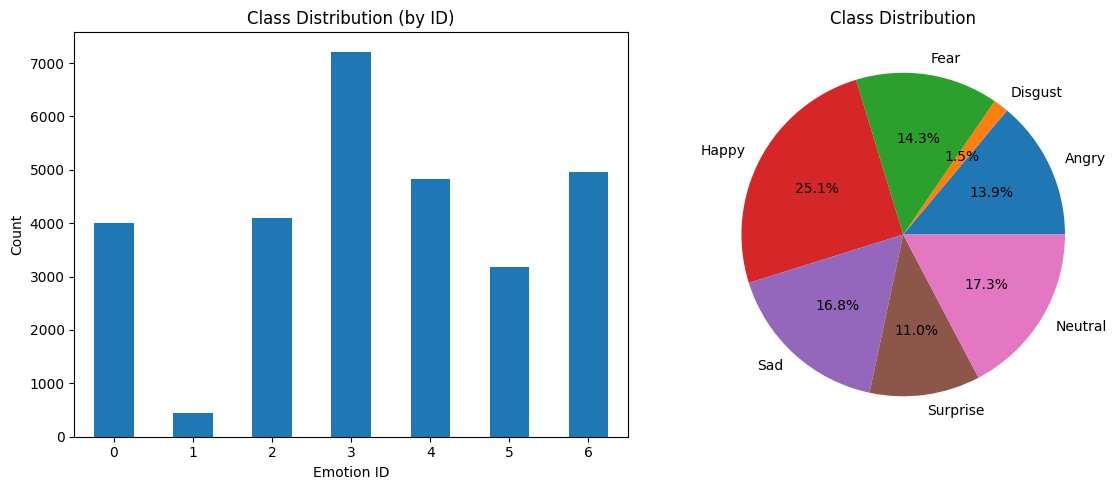

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
emotion_counts.plot(kind='bar')
plt.title('Class Distribution (by ID)')
plt.xlabel('Emotion ID')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
expression_names = [expression_mapping[i] for i in emotion_counts.index]
plt.pie(emotion_counts.values, labels=expression_names, autopct='%1.1f%%')
plt.title('Class Distribution')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Log class distribution to wandb
wandb.log({
    "class_distribution": wandb.Image("class_distribution.png"),
    "total_samples": len(train_df),
    "num_classes": len(expression_mapping),
    "class_balance": emotion_counts.to_dict()
})

#  Analyze image dimensions and pixel values

<ipython-input-13-8f0c1d8f0edb>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_indices = train_df.groupby('emotion').apply(lambda x: x.sample(3)).index.get_level_values(1)


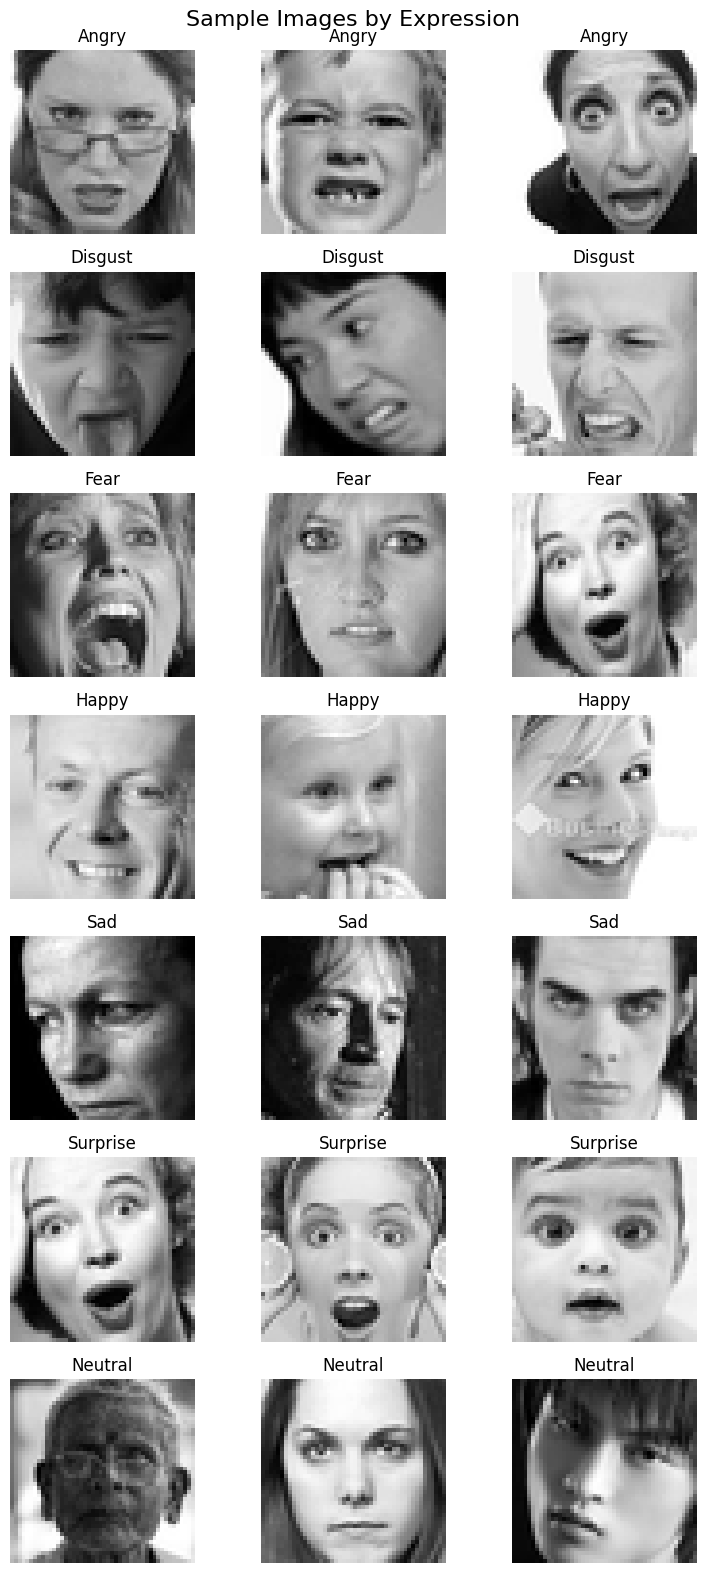

In [13]:

def pixels_to_image(pixel_string, img_size=48):
    """Convert pixel string to numpy array"""
    pixels = np.array(pixel_string.split(), dtype=np.uint8)
    return pixels.reshape(img_size, img_size)

# Sample some images
sample_indices = train_df.groupby('emotion').apply(lambda x: x.sample(3)).index.get_level_values(1)
sample_data = train_df.loc[sample_indices]

# Create visualization of sample images
fig, axes = plt.subplots(len(expression_mapping), 3, figsize=(8, 16))
fig.suptitle('Sample Images by Expression', fontsize=16)

for i, (emotion_id, emotion_name) in enumerate(expression_mapping.items()):
    emotion_samples = sample_data[sample_data['emotion'] == emotion_id]

    for j, (idx, row) in enumerate(emotion_samples.iterrows()):
        if j >= 3:  # Only show 3 samples per emotion
            break

        img = pixels_to_image(row['pixels'])
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f'{emotion_name}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze pixel value statistics



Pixel Value Analysis:
Pixel value range: 0 - 255
Mean pixel value: 131.00
Std pixel value: 64.35


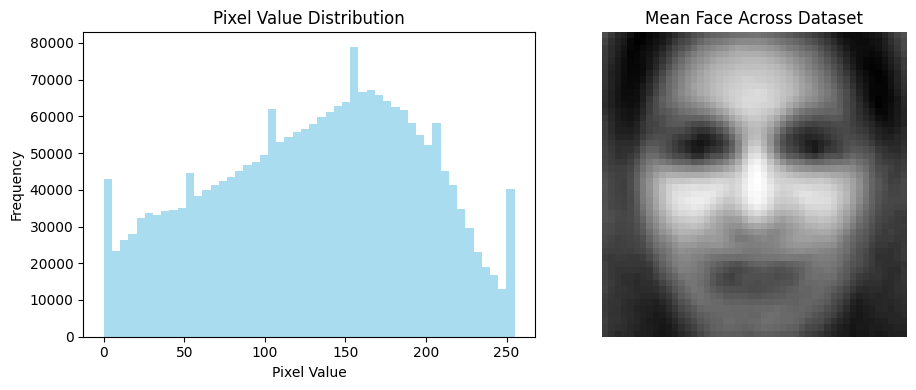

In [14]:
# Analyze pixel value statistics
print("\nPixel Value Analysis:")
sample_pixels = []
for i in range(min(1000, len(train_df))):  # Sample 1000 images for analysis
    pixels = np.array(train_df.iloc[i]['pixels'].split(), dtype=np.uint8)
    sample_pixels.extend(pixels)

sample_pixels = np.array(sample_pixels)
print(f"Pixel value range: {sample_pixels.min()} - {sample_pixels.max()}")
print(f"Mean pixel value: {sample_pixels.mean():.2f}")
print(f"Std pixel value: {sample_pixels.std():.2f}")

# Plot pixel value distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(sample_pixels, bins=50, alpha=0.7, color='skyblue')
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Show mean image across all samples
mean_pixels = []
for i in range(min(1000, len(train_df))):
    pixels = np.array(train_df.iloc[i]['pixels'].split(), dtype=np.uint8)
    mean_pixels.append(pixels)
mean_image = np.mean(mean_pixels, axis=0).reshape(48, 48)
plt.imshow(mean_image, cmap='gray')
plt.title('Mean Face Across Dataset')
plt.axis('off')

plt.tight_layout()
plt.savefig('pixel_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# Create train/validation split


In [15]:

train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['emotion'],
    random_state=42
)

print(f"\nData Split:")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Check class distribution in splits
train_split_dist = train_df.iloc[train_indices]['emotion'].value_counts().sort_index()
val_split_dist = train_df.iloc[val_indices]['emotion'].value_counts().sort_index()

print("\nClass distribution in splits:")
for emotion_id in range(7):
    train_pct = train_split_dist[emotion_id] / len(train_indices) * 100
    val_pct = val_split_dist[emotion_id] / len(val_indices) * 100
    print(f"{expression_mapping[emotion_id]}: Train {train_pct:.1f}%, Val {val_pct:.1f}%")

# Log additional metrics to wandb
wandb.log({
    "sample_images": wandb.Image("sample_images.png"),
    "pixel_analysis": wandb.Image("pixel_analysis.png"),
    "pixel_mean": float(sample_pixels.mean()),
    "pixel_std": float(sample_pixels.std()),
    "image_size": "48x48",
    "train_samples": len(train_indices),
    "val_samples": len(val_indices)
})


Data Split:
Training samples: 22967
Validation samples: 5742

Class distribution in splits:
Angry: Train 13.9%, Val 13.9%
Disgust: Train 1.5%, Val 1.5%
Fear: Train 14.3%, Val 14.3%
Happy: Train 25.1%, Val 25.1%
Sad: Train 16.8%, Val 16.8%
Surprise: Train 11.0%, Val 11.0%
Neutral: Train 17.3%, Val 17.3%


# Data quality checks

In [16]:

print("\nData Quality Checks:")

# Check for missing values
print(f"Missing values in training set: {train_df.isnull().sum().sum()}")
print(f"Missing values in test set: {test_df.isnull().sum().sum()}")

# Check for duplicate images (by pixel values)
duplicate_count = train_df['pixels'].duplicated().sum()
print(f"Duplicate images: {duplicate_count}")

# Check pixel string lengths (should all be 48*48=2304)
pixel_lengths = train_df['pixels'].apply(lambda x: len(x.split()))
print(f"Pixel string lengths - Min: {pixel_lengths.min()}, Max: {pixel_lengths.max()}, Unique: {pixel_lengths.nunique()}")

if pixel_lengths.nunique() > 1:
    print("Warning: Inconsistent image sizes detected!")
    print(pixel_lengths.value_counts())

# Basic statistics summary
summary_stats = {
    "dataset_size": len(train_df),
    "num_classes": len(expression_mapping),
    "image_dimensions": "48x48",
    "color_channels": 1,  # grayscale
    "class_imbalance_ratio": emotion_counts.max() / emotion_counts.min(),
    "most_common_class": expression_mapping[emotion_counts.idxmax()],
    "least_common_class": expression_mapping[emotion_counts.idxmin()],
    "pixel_value_range": f"{sample_pixels.min()}-{sample_pixels.max()}",
    "mean_pixel_value": float(sample_pixels.mean()),
    "data_quality_issues": {
        "missing_values": int(train_df.isnull().sum().sum()),
        "duplicates": int(duplicate_count),
        "inconsistent_sizes": bool(pixel_lengths.nunique() > 1)
    }
}

print("\nDataset Summary:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# Log summary to wandb
wandb.log({"dataset_summary": summary_stats})


Data Quality Checks:
Missing values in training set: 0
Missing values in test set: 0
Duplicate images: 1236
Pixel string lengths - Min: 2304, Max: 2304, Unique: 1

Dataset Summary:
dataset_size: 28709
num_classes: 7
image_dimensions: 48x48
color_channels: 1
class_imbalance_ratio: 16.548165137614678
most_common_class: Happy
least_common_class: Disgust
pixel_value_range: 0-255
mean_pixel_value: 130.9997890625
data_quality_issues: {'missing_values': 0, 'duplicates': 1236, 'inconsistent_sizes': False}


In [18]:

# Save processed indices for future use
np.save('train_indices.npy', train_indices)
np.save('val_indices.npy', val_indices)

print("\nData exploration complete!")
print("Key findings:")
print("1. Dataset has 7 emotion classes with class imbalance")
print("2. Images are 48x48 grayscale")
print("3. Pixel values range 0-255 with reasonable distribution")
print(f"4. Class imbalance ratio: {summary_stats['class_imbalance_ratio']:.2f}")
print("5. Train/validation split created and saved")

wandb.finish()



Data exploration complete!
Key findings:
1. Dataset has 7 emotion classes with class imbalance
2. Images are 48x48 grayscale
3. Pixel values range 0-255 with reasonable distribution
4. Class imbalance ratio: 16.55
5. Train/validation split created and saved
